## Importing Libraries

In [56]:
import cv2
import os
import random
import re
import warnings
from random import shuffle
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.util.shape import view_as_blocks
from skimage import io, transform
from tqdm import tqdm
import tensorflow as tf

from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPooling2D
from keras.models import load_model

## Loading Data

In [28]:
def load_and_shuffle_data(dataset_path, size):
    data = glob(dataset_path)
    shuffle(data)
    return data[:size]

train_size = 10000
test_size = 2000
train = load_and_shuffle_data("./dataset/train/*.jpeg", train_size)
test = load_and_shuffle_data("./dataset/test/*.jpeg", test_size)

# piece symbols to be used in FEN definitions
piece_notation = 'prbnkqPRBNKQ'

In [29]:
def get_fen(filename):
    return os.path.splitext(os.path.basename(filename))[0]

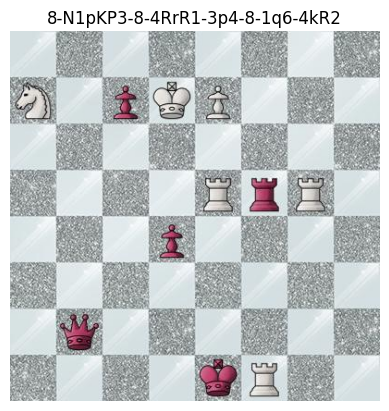

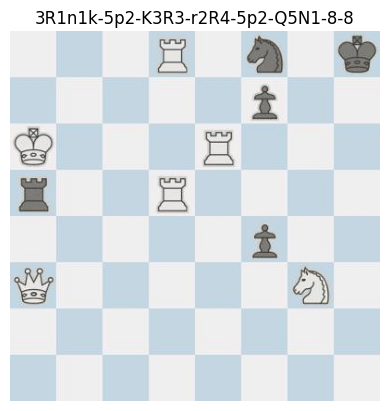

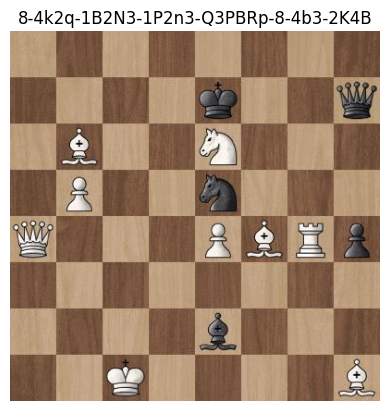

In [30]:
for index in range(3):
    current_filename = train[index]
    current_fen = get_fen(current_filename)
    
    plt.title(current_fen)
    plt.imshow(mpimg.imread(current_filename))
    plt.axis('off')
    plt.show()

In [31]:
pixel_height = 25
pixel_width = 25
num_classes = 13
EPOCHS = 100
BATCH_SIZE = 8

### Convert FEN to One-Hot Encoding and Vice-Versa

In [32]:
#  converts FEN chessboard position into a one-hot encoded matrix
def fen_to_onehot(fen):
    identity_matrix = np.eye(num_classes)
    oh_output = np.empty((0, num_classes))
    fen = re.sub('[-]', '', fen)

    for char in fen:
        if(char in '12345678'):
            oh_output = np.append(
              oh_output, np.tile(identity_matrix[12], (int(char), 1)), axis=0)
        else:
            idx = piece_notation.index(char)
            oh_output = np.append(oh_output, identity_matrix[idx].reshape((1, num_classes)), axis=0)

    return oh_output

# converts a chessboard representation in one-hot encoding format to FEN
def onehot_to_fen(one_hot):
    fen_output = ''
    for j in range(8):
        for i in range(8):
            if(one_hot[j][i] == 12):
                fen_output += ' '
            else:
                fen_output += piece_notation[one_hot[j][i]]
        if(j != 7):
            fen_output += '-'

    for i in range(8, 0, -1):
        fen_output = fen_output.replace(' ' * i, str(i))

    return fen_output

#### Process Images

In [33]:
# resizes and splits an image into 64 square tiles of equal size for further processing
def process_tiles(img):
    downsample_size = 200
    square_size = int(downsample_size/8)
    img_read = io.imread(img)
    img_read = transform.resize(
      img_read, (downsample_size, downsample_size), mode='constant')
    tiles = view_as_blocks(img_read, block_shape=(square_size, square_size, 3))
    tiles = tiles.squeeze(axis=2)

    return tiles.reshape(64, square_size, square_size, 3)

#### Functions for sampling batches for training and evaluation

In [34]:
# Generator function to yield processed images and corresponding one-hot encoded FEN for training
def train_gen(features):
    for _, img in enumerate(features):
        y = fen_to_onehot(get_fen(img))
        x = process_tiles(img)
        yield x, y

# Generator function to yield processed images in batches for making predictions.
def pred_gen(features, batch_size):
    for i, img in enumerate(features):
        yield process_tiles(img)

#### Define Baseline Model

In [35]:
baseline_model = Sequential()
# Add a Flatten layer to flatten the input images
baseline_model.add(Flatten(input_shape=(pixel_height, pixel_width, 3)))
# output layer for classification with 13 classes
baseline_model.add(Dense(13, activation='softmax'))
baseline_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 1875)              0         
                                                                 
 dense_2 (Dense)             (None, 13)                24388     
                                                                 
Total params: 24388 (95.27 KB)
Trainable params: 24388 (95.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
# Compile the model 
baseline_model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [37]:
# Fit parameters
baseline_history = baseline_model.fit(
    train_gen(train), steps_per_epoch=len(train)//EPOCHS,
    epochs=EPOCHS, verbose=1, validation_data=train_gen(test),
    validation_steps=len(test)//EPOCHS
)

Epoch 1/100
100/100 [==============================] - 2s 18ms/step - loss: 0.8211 - accuracy: 0.8408 - val_loss: 0.4901 - val_accuracy: 0.8867
Epoch 2/100
100/100 [==============================] - 2s 17ms/step - loss: 0.5257 - accuracy: 0.8794 - val_loss: 0.5308 - val_accuracy: 0.8898
Epoch 3/100
100/100 [==============================] - 2s 17ms/step - loss: 0.4442 - accuracy: 0.9031 - val_loss: 0.4344 - val_accuracy: 0.9375
Epoch 4/100
100/100 [==============================] - 2s 16ms/step - loss: 0.3765 - accuracy: 0.9208 - val_loss: 0.3941 - val_accuracy: 0.9148
Epoch 5/100
100/100 [==============================] - 2s 15ms/step - loss: 0.2988 - accuracy: 0.9339 - val_loss: 0.3480 - val_accuracy: 0.9383
Epoch 6/100
100/100 [==============================] - 1s 14ms/step - loss: 0.2689 - accuracy: 0.9367 - val_loss: 0.2686 - val_accuracy: 0.9383
Epoch 7/100
100/100 [==============================] - 1s 15ms/step - loss: 0.2367 - accuracy: 0.9488 - val_loss: 0.2313 - val_accuracy:

100/100 [==============================] - 1s 15ms/step - loss: 0.0639 - accuracy: 0.9855 - val_loss: 0.0387 - val_accuracy: 0.9898
Epoch 58/100
100/100 [==============================] - 1s 15ms/step - loss: 0.0558 - accuracy: 0.9853 - val_loss: 0.0644 - val_accuracy: 0.9891
Epoch 59/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0572 - accuracy: 0.9886 - val_loss: 0.0888 - val_accuracy: 0.9758
Epoch 60/100
100/100 [==============================] - 2s 15ms/step - loss: 0.0531 - accuracy: 0.9884 - val_loss: 0.0637 - val_accuracy: 0.9836
Epoch 61/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0584 - accuracy: 0.9867 - val_loss: 0.0527 - val_accuracy: 0.9945
Epoch 62/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0679 - accuracy: 0.9847 - val_loss: 0.0349 - val_accuracy: 0.9906
Epoch 63/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0783 - accuracy: 0.9808 - val_loss: 0.0555 - val_accuracy: 0.985

In [12]:
# save the model to call it later when needed
baseline_model.save('baseline_model.keras')

### Baseline Evaluation

In [38]:
# performs predictions using the baseline_model on test data and reshapes the results
baseline_result = (
    baseline_model.predict(pred_gen(test, 64), steps=test_size)
    .argmax(axis=1)
    .reshape(-1, 8, 8)
)

2000/2000 [==============================] - 29s 15ms/step


In [39]:
# computes accuracy of predictions made by comparing FEN representations of predicted and test data
baseline_pred_fens = np.array([onehot_to_fen(one_hot) for one_hot in baseline_result])
baseline_test_fens = np.array([get_fen(fn) for fn in test])

baseline_final_accuracy = (baseline_pred_fens == baseline_test_fens).astype(float).mean()

print("Accuracy: {:2f}".format(baseline_final_accuracy))

Accuracy: 0.733000


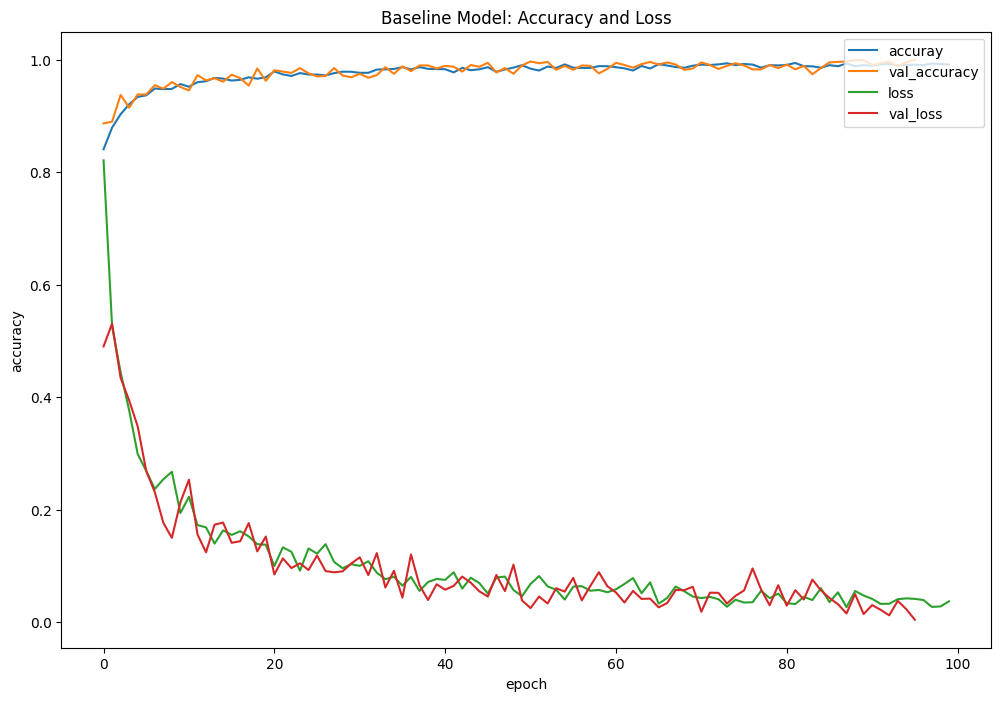

In [40]:
# generates a plot to visualize the training history (accuracy and loss) of a baseline model
baseline_fig = plt.figure(figsize=(12, 8))
plt.plot(baseline_history.history['accuracy'])
plt.plot(baseline_history.history['val_accuracy'])
plt.plot(baseline_history.history['loss'])
plt.plot(baseline_history.history['val_loss'])
plt.title('Baseline Model: Accuracy and Loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuray', 'val_accuracy', 'loss', 'val_loss'], loc='upper right')
plt.show()

### Advanced Model

In [41]:
adv_model = Sequential()
# Convolutional 2D layer
adv_model.add(Conv2D(15, kernel_size=2, activation='relu', input_shape=(pixel_height, pixel_width, 3)))
# Pooling operation
adv_model.add(MaxPooling2D(2))
# Add another convolutional layer
adv_model.add(Conv2D(5, kernel_size=2, activation='relu'))
# Flatten and feed to output layer
adv_model.add(Flatten())
# Add a dropout layer
adv_model.add(Dropout(0.3))
# Output layer
adv_model.add(Dense(13, activation='softmax'))
adv_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 24, 24, 15)        195       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 15)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 5)         305       
                                                                 
 flatten_3 (Flatten)         (None, 605)               0         
                                                                 
 dropout_1 (Dropout)         (None, 605)               0         
                                                                 
 dense_3 (Dense)             (None, 13)                7878      
                                                      

In [42]:
# Compile the model 
adv_model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

### Model Training

In [43]:
# Fit parameters
adv_history = adv_model.fit(
    train_gen(train), steps_per_epoch=len(train)//EPOCHS,
    epochs=EPOCHS, verbose=1, validation_data=train_gen(test),
    validation_steps=len(test)//EPOCHS
)

Epoch 1/100
100/100 [==============================] - 2s 19ms/step - loss: 1.1247 - accuracy: 0.7991 - val_loss: 0.6811 - val_accuracy: 0.8578
Epoch 2/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6286 - accuracy: 0.8439 - val_loss: 0.5510 - val_accuracy: 0.8555
Epoch 3/100
100/100 [==============================] - 2s 17ms/step - loss: 0.4322 - accuracy: 0.8858 - val_loss: 0.3259 - val_accuracy: 0.9055
Epoch 4/100
100/100 [==============================] - 2s 17ms/step - loss: 0.2533 - accuracy: 0.9334 - val_loss: 0.2056 - val_accuracy: 0.9469
Epoch 5/100
100/100 [==============================] - 2s 16ms/step - loss: 0.1745 - accuracy: 0.9566 - val_loss: 0.1768 - val_accuracy: 0.9508
Epoch 6/100
100/100 [==============================] - 1s 15ms/step - loss: 0.1159 - accuracy: 0.9675 - val_loss: 0.1094 - val_accuracy: 0.9734
Epoch 7/100
100/100 [==============================] - 1s 15ms/step - loss: 0.1053 - accuracy: 0.9756 - val_loss: 0.0718 - val_accuracy:

100/100 [==============================] - 1s 15ms/step - loss: 0.0367 - accuracy: 0.9912 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 58/100
100/100 [==============================] - 2s 15ms/step - loss: 0.0190 - accuracy: 0.9958 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 59/100
100/100 [==============================] - 1s 15ms/step - loss: 0.0058 - accuracy: 0.9989 - val_loss: 0.0064 - val_accuracy: 0.9992
Epoch 60/100
100/100 [==============================] - 1s 15ms/step - loss: 0.0071 - accuracy: 0.9980 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 61/100
100/100 [==============================] - 1s 15ms/step - loss: 0.0044 - accuracy: 0.9986 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 62/100
100/100 [==============================] - 1s 15ms/step - loss: 0.0045 - accuracy: 0.9987 - val_loss: 7.9920e-04 - val_accuracy: 1.0000
Epoch 63/100
100/100 [==============================] - 2s 15ms/step - loss: 0.0045 - accuracy: 0.9984 - val_loss: 0.0019 - val_accuracy: 1

In [19]:
# save the model to call it later when needed
adv_model.save('adv_model.keras')

#### Adv Model Performance Evaluation

In [44]:
# performs predictions using the baseline_model on test data and reshapes the results
adv_result = (
    adv_model.predict(pred_gen(test, 64), steps=test_size)
    .argmax(axis=1)
    .reshape(-1, 8, 8)
)

2000/2000 [==============================] - 29s 14ms/step


In [45]:
# computes accuracy of predictions made by comparing FEN representations of predicted and test data
adv_pred_fens = np.array([onehot_to_fen(one_hot) for one_hot in adv_result])
adv_test_fens = np.array([get_fen(fn) for fn in test])

adv_final_accuracy = (adv_pred_fens == adv_test_fens).astype(float).mean()

print("Accuracy: {:2f}".format(adv_final_accuracy))

Accuracy: 1.000000


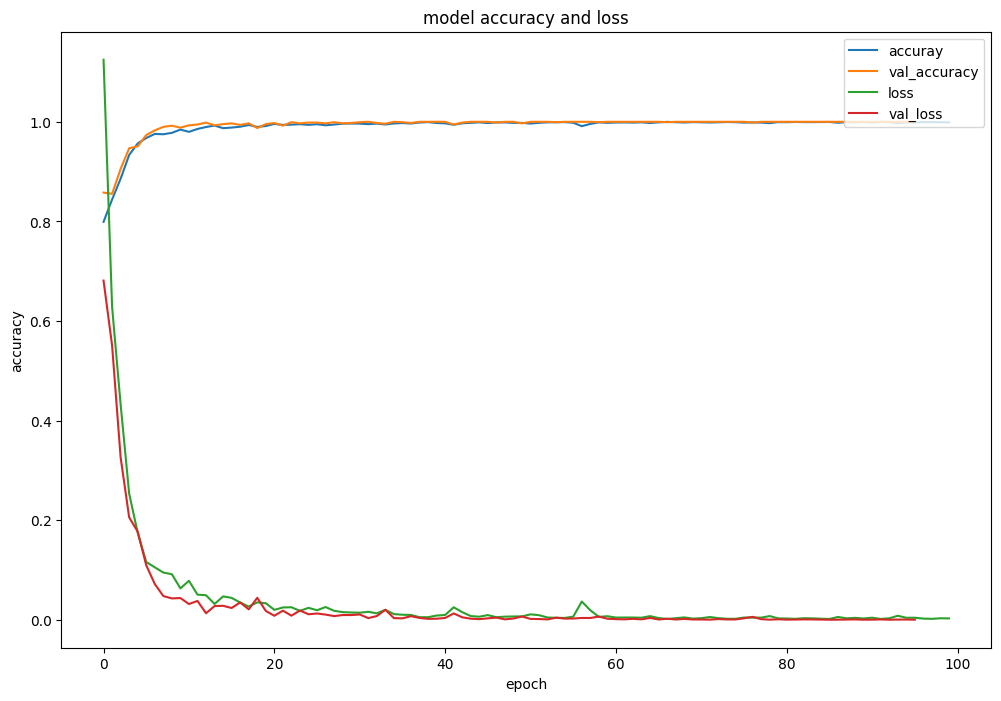

In [49]:
# generates a plot to visualize the training history (accuracy and loss) of adv model
adv_fig = plt.figure(figsize=(12, 8))
plt.plot(adv_history.history['accuracy'])
plt.plot(adv_history.history['val_accuracy'])
plt.plot(adv_history.history['loss'])
plt.plot(adv_history.history['val_loss'])
plt.title('Adv Model: Accuracy and Loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuray', 'val_accuracy', 'loss', 'val_loss'], loc='upper right')
plt.show()

#### Chess Board Prediction

2/2 [==============================] - 0s 1ms/step


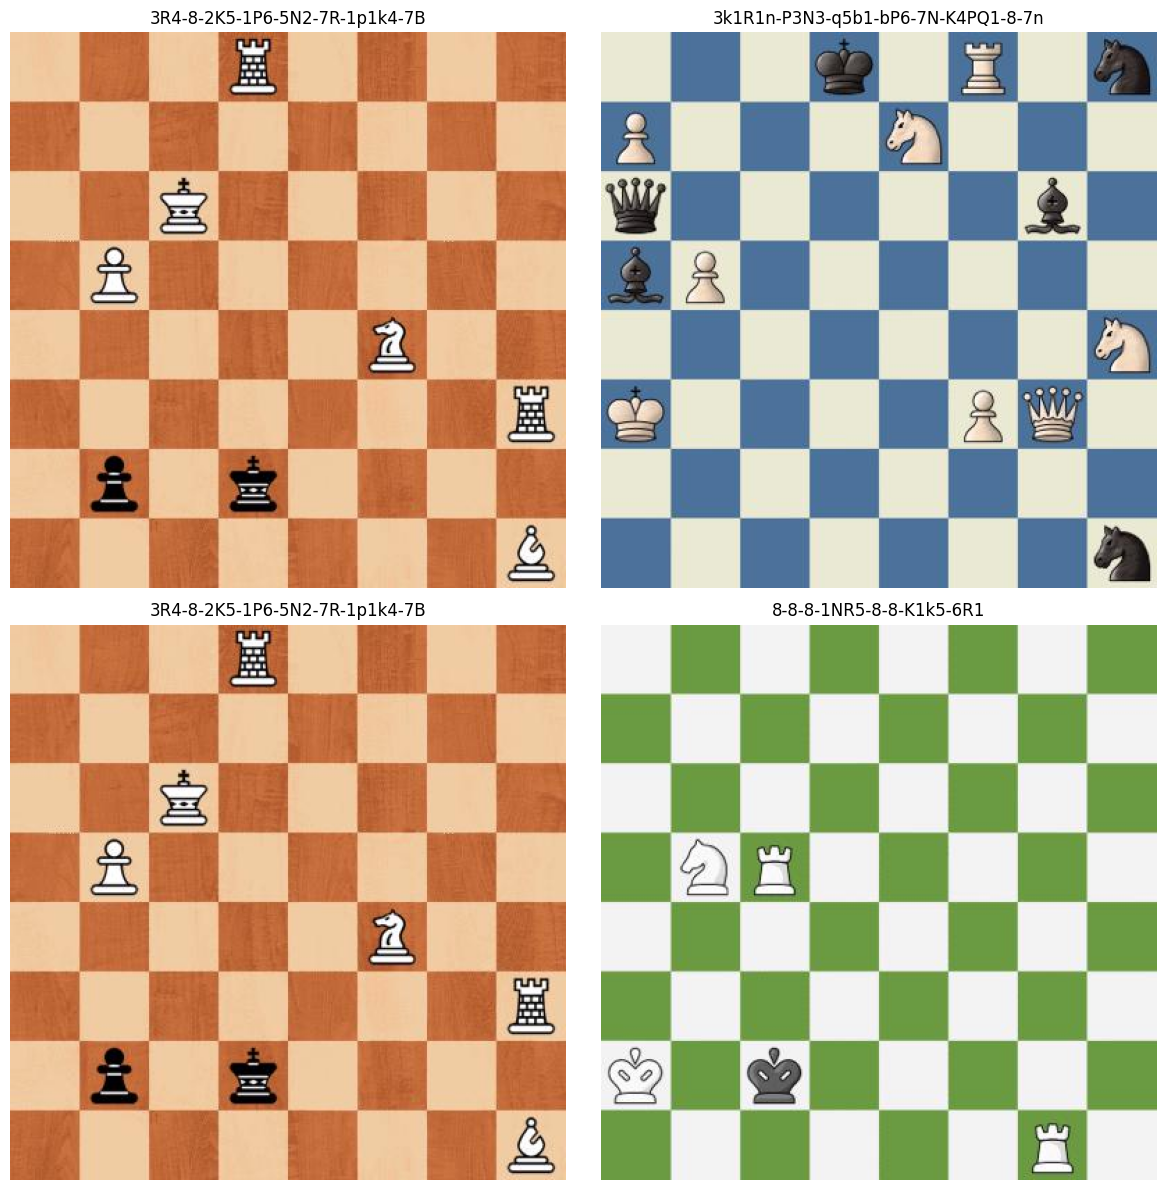

In [60]:
# def predicted_fen_board(images, model):
#     plt.figure(figsize=(12, 12))
#     num_rows, num_cols = 2, 2

#     for i in range(num_rows * num_cols):
#         plt.subplot(num_rows, num_cols, i + 1)
#         rand_idx = random.randint(0, len(images) - 1)
#         image = images[rand_idx]

#         pred = adv_model.predict(process_tiles(image)).argmax(axis=1).reshape(-1, 8, 8)
#         fen = onehot_to_fen(pred[0])

#         imgplot = plt.imshow(mpimg.imread(image))
#         plt.axis('off')
#         plt.title(fen)

#     plt.tight_layout()
#     plt.show()

# selected_images = random.sample(test, 4)
# predicted_fen_board(selected_images, adv_model)

2/2 [==============================] - 0s 2ms/step


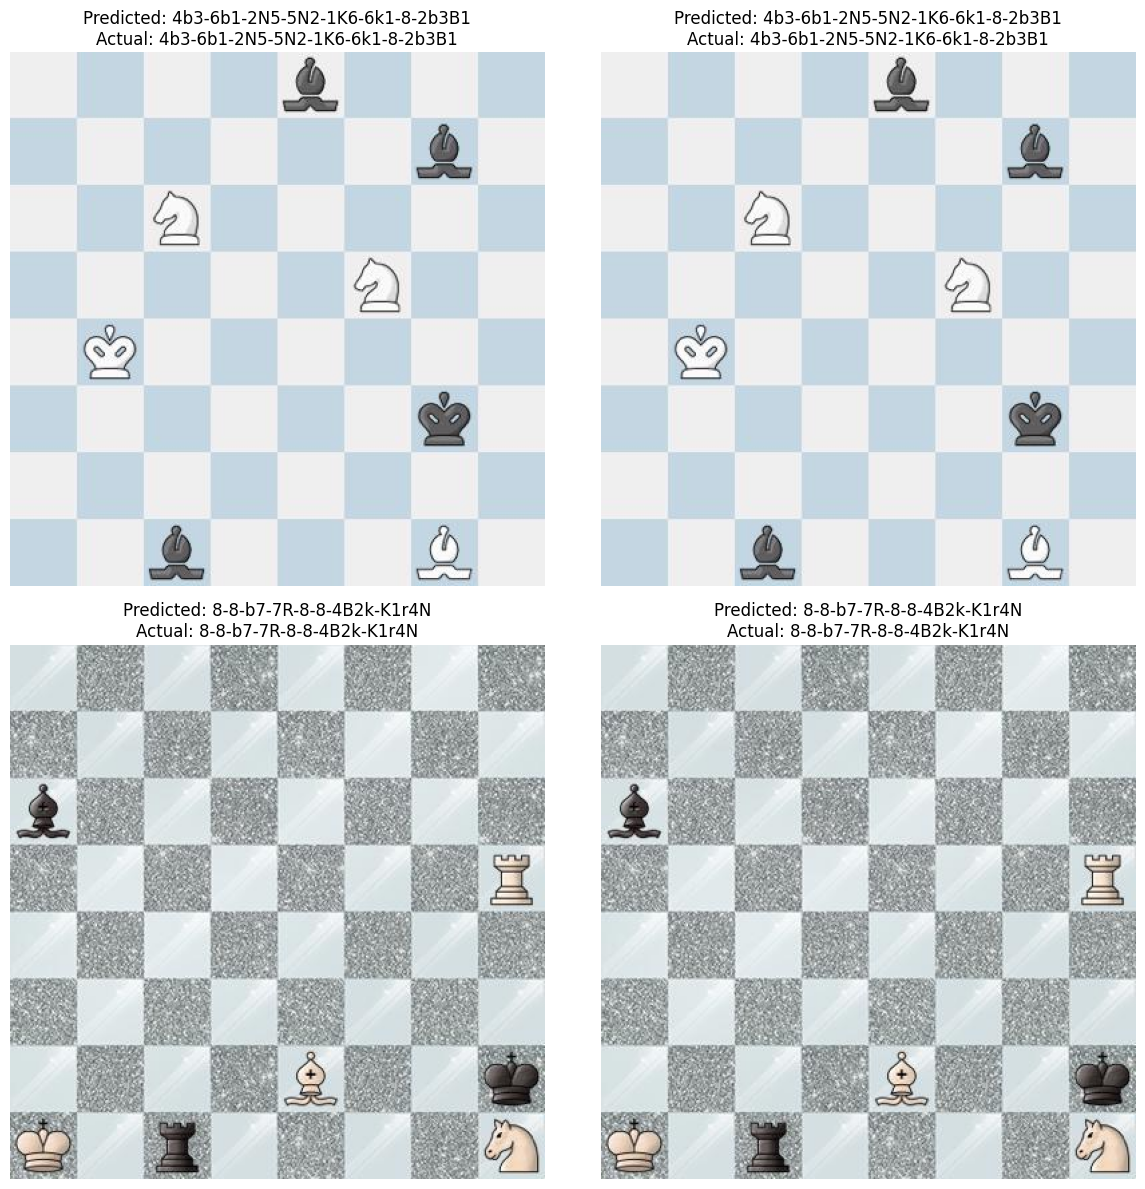

In [61]:
def predicted_fen_board(images, model):
    plt.figure(figsize=(12, 12))
    num_rows, num_cols = 2, 2

    for i in range(num_rows * num_cols):
        plt.subplot(num_rows, num_cols, i + 1)
        rand_idx = random.randint(0, len(images) - 1)
        image_path = images[rand_idx]
        image = process_tiles(image_path)

        pred = model.predict(image).argmax(axis=1).reshape(-1, 8, 8)
        predicted_fen = onehot_to_fen(pred[0])
        actual_fen = get_fen(image_path)

        imgplot = plt.imshow(mpimg.imread(image_path))
        plt.axis('off')
        plt.title(f'Predicted: {predicted_fen}\nActual: {actual_fen}')

    plt.tight_layout()
    plt.show()

selected_images = random.sample(test, 4)
predicted_fen_board(selected_images, adv_model)